In [1]:
from helpers_processing import json_to_csv, unique_display_link, remove_most_popular, expand_labels, unique_display_link_prediction, labeling
from helpers_classification import data_preparation, training, compute_nb_errors, predict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn, argmax
import torch
sns.set_style("white")

## Processing Pipeline

In [2]:
json_to_csv('../data/google.json', '../data/data_processed.csv')

unique_display_link('../data/data_processed.csv', '../data/unique_displayLink.csv')

remove_most_popular('../data/unique_displayLink.csv', '../data/drug_websites_filtered.csv','../data/top-1m.csv')

expand_labels('../data/labelled_unique.csv', '../data/data_processed.csv', '../data/labelled_expanded.csv')

## Exploration

In [2]:
df = pd.read_csv('../data/labelled_expanded.csv', index_col='link')

In [3]:
print("There are a total of {} links listed of which {} are labelled. {} labelled are not webshops, {} are webshops and {} are dead links.""".format(len(df), 
                                                           len(df[~df['label'].isnull()]),\
                                                           len(df[df['label'] == 0.0]),\
                                                           len(df[df['label'] == 1.0]),\
                                                           len(df[df['label'] == 2.0])))

There are a total of 101320 links listed of which 30246 are labelled. 19196 labelled are not webshops, 4314 are webshops and 6736 are dead links.


In [4]:
num_samples = len(df[~df['label'].isnull()])
average_wordcount = df.text.str.split().apply(len).mean()
ratio = num_samples / average_wordcount

In [5]:
print("The average wordcount of the text per sample is {0:f}. The cited google article \
on text classification thus proposes to use a multilayer perceptron, because the ratio \
num_samples / average wordcount is {1:f} and thus less than 1500."
      .format(average_wordcount, ratio))
      

The average wordcount of the text per sample is 32.799092. The cited google article on text classification thus proposes to use a multilayer perceptron, because the ratio num_samples / average wordcount is 922.159675 and thus less than 1500.


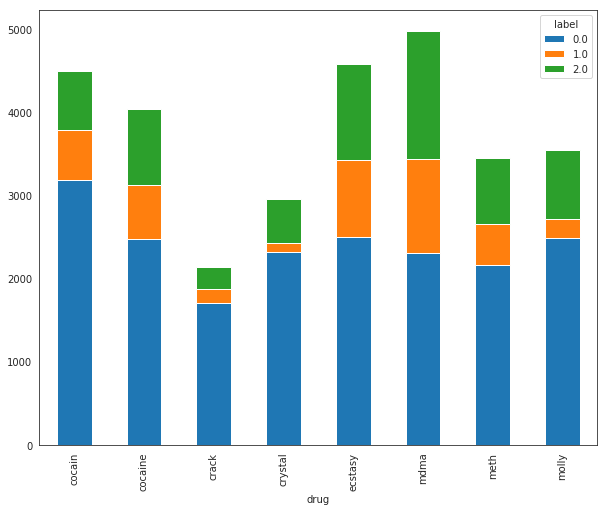

In [6]:
df.groupby(['drug','label']).size().unstack().plot(kind='bar', stacked=True, figsize=(10,8));
plt.savefig('../figures/drug_distribution.eps',format='eps')

From the above plot we can see that for the words 'crack', 'crystal' and 'molly there are many false positives and little true positives.

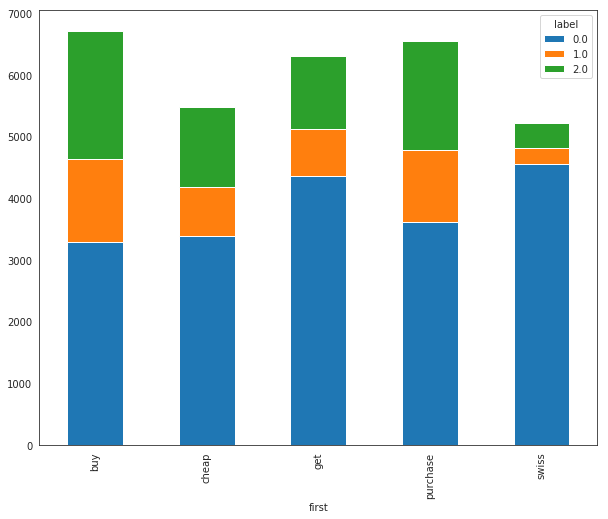

In [7]:
df.groupby(['first','label']).size().unstack().plot(kind='bar', stacked=True, figsize=(10,8));
plt.savefig('../figures/first_distribution.eps',format='eps')

We can see that the word 'swiss' has almost no true positives.

## Classification Pipeline

In [8]:
x_train, y_train, x_test, y_test, unlabelled_data, unlabelled = data_preparation('../data/labelled_expanded.csv')

In [9]:
model = nn.Sequential(
        nn.Linear(10000, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 64),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(64,1),
        nn.Sigmoid())

In [10]:
training(model, x_train, y_train)

Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90


In [46]:
nb_data_errors_train, fp_train, fn_train = compute_nb_errors(model, x_train, y_train)
nb_data_errors_test, fp_test, fn_test = compute_nb_errors(model, x_test, y_test)

In [47]:
print('Training accuracy: ' + str(round(100 - (nb_data_errors_train / x_train.size(0)*100),2)) + ' %')
print('Test accuracy: ' + str(round(100 - (nb_data_errors_test / x_test.size(0) * 100),2)) + ' %')
print('On the test set there were a total of {} samples. {} with the label 0 and {} with the label 0. \
There are {} false positives and {} false negatives.'.format(len(x_test), int(len(y_test) - y_test.sum()), int(y_test.sum()), fp_test, fn_test))

Training accuracy: 99.89 %
Test accuracy: 99.28 %
On the test set there were a total of 4700 samples. 3802 with the label 0 and 898 with the label 0. There are 15 false positives and 19 false negatives.


In [31]:
torch.save(model, '../models/mlp.pt')

In [32]:
model = torch.load('../models/mlp.pt')

In [33]:
predict(unlabelled_data, unlabelled, model, '../data/labelled_prediction_expanded.csv')

In [34]:
unique_display_link_prediction('../data/labelled_prediction_expanded.csv',
                               '../data/labelled_prediction_unique.csv')

In [35]:
df = pd.read_csv('../data/labelled_prediction_unique.csv', index_col='displayLink')

## Exploring the predictions

In [45]:
print('Of the {} unlabelled display links {} are predicted to be, or to have been, illegal webshops.'.format(len(df), len(df[df['label']==1])))

Of the 14043 unlabelled display links 602 are predicted to be, or to have been, illegal webshops.


In [36]:
df[df['label']==1].head(20)

,text,first,drug,count,label,ratio,label_count
displayLink,,,,,,,
www.medicalmarijuanasupliez.com,Buy crack cocaine for sale | buy powder cocain...,purchase,cocaine,54,1,1.0,54
buycokeonline.com,buy crack online | Buy Coke Online | Bitcoins ...,buy,crack,49,1,1.0,49
home-supplies.info,Buy Pure Cocain Online — Home Supplies Buy Pur...,purchase,crack,43,1,1.0,43
bestsyrupshop.com,buy cocaine for sale online with credit card |...,purchase,crack,40,1,1.0,40
seasidebathsalt.com,cocaine for sale online | order cocaine online...,purchase,cocaine,23,1,1.0,23
bestmedsstore.com,buy cocaine online - cocaine for sale - buy co...,purchase,cocaine,22,1,1.0,22
researchchemicalintermediates.wholesale.wneducation.com,"Research Chemicals BK MDMA, Research Chemicals...",cheap,mdma,18,1,1.0,18
buycocaineonlineusa.com,"Buy Cocaine Online, Cocaine for sale, Buy crac...",buy,cocaine,18,1,1.0,18
www.neropharma.com,"Pure Cocaine for sale,buy pure Cocain online,o...",cheap,cocaine,17,1,1.0,17


In [37]:
df[df['label']==0].tail(20)

,text,first,drug,count,label,ratio,label_count
displayLink,,,,,,,
www.usatoday.com,"Sep 24, 2018 ... Oct. 31: Meth found in trick-...",swiss,meth,61,0,0.0,0
www.wnpr.org,"Sep 26, 2013 ... Millions of Americans have se...",swiss,meth,3,0,0.0,0
arxiv.org,The beamline is installed at Swiss Light Sourc...,swiss,meth,5,0,0.0,0
symbiosisonlinepublishing.com,Augmentation of Antioxidant Status in the Live...,swiss,meth,1,0,0.0,0
en.swisswebcams.ch,More than 3300 webcams of Swiss landscapes. .....,swiss,molly,48,0,0.0,0
cointelegraph.com,"Jul 31, 2018 ... News. Online banking service ...",swiss,molly,17,0,0.0,0
www.eda.admin.ch,Online desk FDFA. Using the FDFA's online cons...,swiss,molly,9,0,0.0,0
exchangerate-euro.com,"Monday, 11.2.2019 (Swiss Franc) - up-to-date e...",swiss,molly,2,0,0.0,0
www.dailymail.co.uk,"Jul 18, 2017 ... Swiss couple who went missing...",swiss,molly,2076,0,0.0,0
